Experimenting with structure of XGBoost algorithm including parameters, possible feature engineering, and most importantly, forecasting setup (masked input and evaluation)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from itertools import chain

In [70]:

# Load the data
df = pd.read_csv('Dataset_1//5visit_MCI_AD.csv')

def create_target_variable(row):
    id  = row['Prog_ID']
    return id

def expand_visits(df):
    """
    Expands a DataFrame where features are stored as arrays (e.g., "[val1, val2, val3]")
    into one row per visit. Automatically detects the maximum number of visits.
    
    Args:
        df (pd.DataFrame): Input data with array-like columns.
    
    Returns:
        pd.DataFrame: Long-format data with one row per visit.
    """
    # Initialize list to store all records
    records = []
    
    for _, row in df.iterrows():
        # Determine max visits by checking the first array-like column
        num_visits = None
        for col in df.columns:
            if isinstance(row[col], str) and row[col].startswith('['):
                num_visits = len(row[col].split(','))
                break
        
        if num_visits is None:
            raise ValueError("No array-like columns found. Check data format.")
        
        # For each visit, extract values
        for visit in range(num_visits):
            record = {}
            for col in df.columns:
                if isinstance(row[col], str) and row[col].startswith('['):
                    try:
                        # Extract the i-th visit value
                        val = row[col].replace('[', '').replace(']', '').split(',')[visit].strip()
                        record[col] = float(val) if val.replace('.', '', 1).isdigit() else val
                    except (IndexError, ValueError):
                        record[col] = np.nan
                else:
                    # Copy non-array values for all visits
                    record[col] = row[col]
            
            # Add visit number
            record['visit_number'] = visit + 1
            records.append(record)
    
    return pd.DataFrame(records)

# Preprocess the data
def preprocess_data(df):
    # Create target variable
    df['target'] = df.apply(create_target_variable, axis=1)
    
    # Select features - adjust based on your domain knowledge
    features = [
        'SEX', 'EDUC', 'ALCOHOL', 'BMI', 'MMSE', 'GDS', 'CDR', 'TOBAC30',
        'BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP', 'EVENTS',
        'PAYATTN', 'REMDATES', 'TRAVEL', 'NACCFAM', 'CVHATT', 'CVAFIB',
        'DIABETES', 'HYPERCHO', 'HYPERTEN', 'B12DEF', 'DEPD', 'ANX', 'NACCTBI',
        'SMOKYRS', 'RACE', 'age'
    ]
    
    # # Extract first visit data (simplifying for initial model)
    # for col in df.columns:
    #     if col in features and df[col].dtype == object:
    #         df[col] = df[col].apply(extract_first_value)
    
    # Handle missing values
    df = df[features + ['target']].copy()
    df = df.dropna(subset=features, how='all')
    
    # Convert categorical variables
    categorical_cols = ['SEX', 'NACCFAM', 'CVHATT', 'CVAFIB', 'DIABETES', 
                       'HYPERCHO', 'HYPERTEN', 'B12DEF', 'DEPD', 'ANX', 'NACCTBI', 'RACE']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    
    return df

df_long = expand_visits(df.copy())
processed_df = preprocess_data(df_long)

# Check class distribution
print("Class distribution:")
print(processed_df['target'].value_counts())

Class distribution:
target
1    580
0     50
Name: count, dtype: int64


In [71]:
def build_model(data):
    # Separate features and target
    X = data.drop('target', axis=1)
    y = data['target']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train XGBoost model
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # Handle class imbalance
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    
    return model, X.columns

# Build and evaluate the model
model2, feature_names = build_model(processed_df)

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.97      0.99       116

    accuracy                           0.98       126
   macro avg       0.88      0.99      0.93       126
weighted avg       0.98      0.98      0.98       126


ROC AUC Score: 0.9974


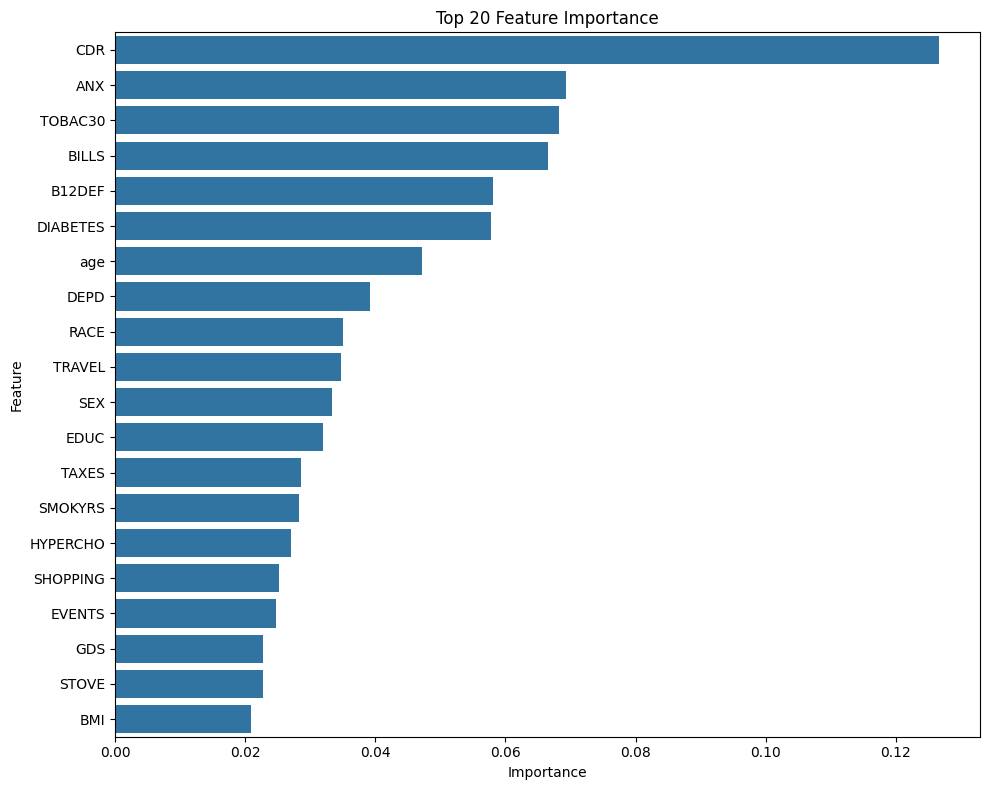

In [69]:
def plot_feature_importance(model, feature_names):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importance')
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(model2, feature_names)

feature engineering method


C:\Users\Andrew\AppData\Local\Temp\ipykernel_9684\3828669154.py:69: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_9684\3828669154.py:72: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_9684\3828669154.py:69: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_9684\3828669154.py:72: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_9684\3828669154.py:69: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_9684\3828669154.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

Class distribution:
target
1    116
0     10
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.95      0.88      0.91        24

    accuracy                           0.85        26
   macro avg       0.60      0.69      0.62        26
weighted avg       0.90      0.85      0.87        26


ROC AUC Score: 0.8750


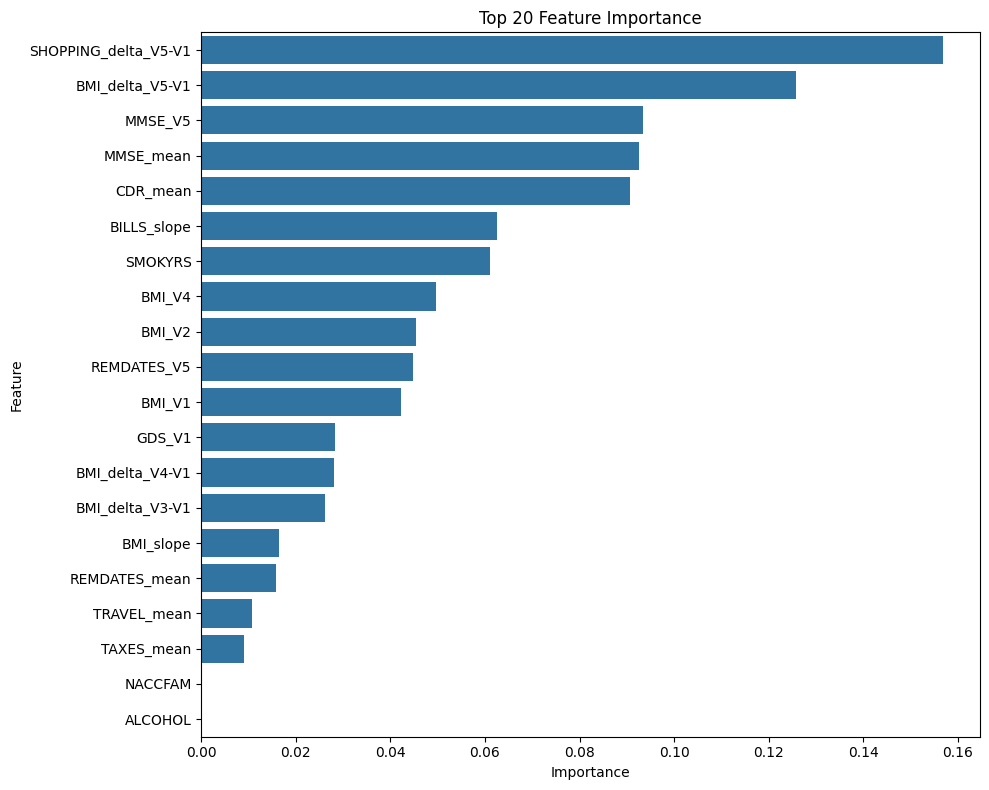

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('Dataset_1//5visit_MCI_AD.csv')

def create_target_variable(row):
    """Create binary target from Progression column (1=progressed, 0=stable)"""
    progression = eval(row['Progression'])  # Convert string tuple to actual tuple
    return 1 if 2 in progression else 0  # 1 if progressed to AD at any visit

def create_delta_features(df):
    """
    Enhanced version that:
    1. Safely parses array strings first
    2. Handles mixed numeric/non-numeric data
    3. Creates features for variable visit lengths
    """
    df = df.copy()
    
    # First pass: Convert all array-strings to lists of floats
    for col in df.columns:
        if df[col].dtype == object and df[col].str.startswith('[').any():
            df[col] = df[col].apply(
                lambda x: [float(v.strip()) if v.strip() != 'nan' else np.nan 
                         for v in x.replace('[','').replace(']','').split(',')] 
                if isinstance(x, str) and x.startswith('[') else np.nan
            )
    
    # Second pass: Create features only for numeric arrays
    for col in df.columns:
        if isinstance(df[col].iloc[0], list) and all(isinstance(v, (int, float)) for v in df[col].iloc[0] if not pd.isna(v)):
            max_visits = max(len(v) for v in df[col] if isinstance(v, list))
            
            # 1. Individual visit values
            for i in range(max_visits):
                df[f"{col}_V{i+1}"] = df[col].apply(
                    lambda x: x[i] if isinstance(x, list) and i < len(x) else np.nan
                )
            
            # 2. Deltas from baseline (V1)
            for i in range(1, max_visits):
                df[f"{col}_delta_V{i+1}-V1"] = df[col].apply(
                    lambda x: x[i]-x[0] if isinstance(x, list) and len(x) > i else np.nan
                )
            
            # 3. Slope of linear trend
            def calc_slope(x):
                if isinstance(x, list) and len(x) > 1:
                    x_vals = np.arange(len(x))
                    y_vals = np.array(x)
                    valid = ~np.isnan(y_vals)
                    if sum(valid) > 1:  # Need at least 2 points
                        return linregress(x_vals[valid], y_vals[valid]).slope
                return np.nan
                
            df[f"{col}_slope"] = df[col].apply(calc_slope)
            
            # 4. Aggregates
            df[f"{col}_mean"] = df[col].apply(
                lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
            )
            df[f"{col}_max"] = df[col].apply(
                lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
            )
    
    # Drop original array columns (keep only engineered features)
    array_cols = [col for col in df.columns if isinstance(df[col].iloc[0], list)] if len(df) > 0 else []
    df = df.drop(columns=array_cols)
    
    return df

# Preprocess the data
def preprocess_data(df):
    # Create target variable
    df['target'] = df.apply(create_target_variable, axis=1)
    
    # Get all available features (after create_delta_features transformation)
    all_features = [col for col in df.columns if col != 'target']
    
    # Select features we want to keep
    # Static features (non-time-series)
    static_features = [
        'SEX', 'EDUC', 'ALCOHOL', 'NACCFAM', 'CVHATT', 
        'CVAFIB', 'DIABETES', 'HYPERCHO', 'HYPERTEN', 'B12DEF', 'DEPD', 
        'ANX', 'NACCTBI', 'SMOKYRS', 'RACE', 'age'
    ]
    
    # Time-series features (we'll keep all of them)
    time_series_features = [col for col in all_features if '_V' in col or '_delta_' in col or '_slope' in col or '_mean' in col or '_max' in col]
    
    # Only keep features that actually exist in the dataframe
    static_features = [f for f in static_features if f in df.columns]
    
    # Combine all features
    features = static_features + time_series_features
    
    # Handle missing values
    df = df[features + ['target']].copy()
    df = df.dropna(subset=features, how='all')
    
    # Convert categorical variables
    categorical_cols = ['SEX', 'NACCFAM', 'CVHATT', 'CVAFIB', 'DIABETES', 
                       'HYPERCHO', 'HYPERTEN', 'B12DEF', 'DEPD', 'ANX', 'NACCTBI', 'RACE']
    categorical_cols = [col for col in categorical_cols if col in df.columns]  # Only keep existing cols
    for col in categorical_cols:
        df[col] = df[col].astype('category').cat.codes  # Convert to numeric codes
    
    return df

# Process the data
df_processed = create_delta_features(df)
processed_df = preprocess_data(df_processed)

# Check class distribution
print("Class distribution:")
print(processed_df['target'].value_counts())

def build_model(data):
    # Separate features and target
    X = data.drop('target', axis=1)
    y = data['target']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Handle class imbalance
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train) if sum(y_train) > 0 else 1
    
    # Train XGBoost model
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    
    return model, X.columns

# Build and evaluate the model
model, feature_names = build_model(processed_df)

def plot_feature_importance(model, feature_names, top_n=20):
    # Get feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
    plt.title(f'Top {top_n} Feature Importance')
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(model, feature_names)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_23364\1623954184.py:69: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_23364\1623954184.py:72: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_23364\1623954184.py:69: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_23364\1623954184.py:72: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_23364\1623954184.py:69: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
C:\Users\Andrew\AppData\Local\Temp\ipykernel_23364\1623954184.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

Class distribution:
target
0    374
1     20
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        75
           1       0.25      0.25      0.25         4

    accuracy                           0.92        79
   macro avg       0.60      0.60      0.60        79
weighted avg       0.92      0.92      0.92        79


ROC AUC Score: 0.8133


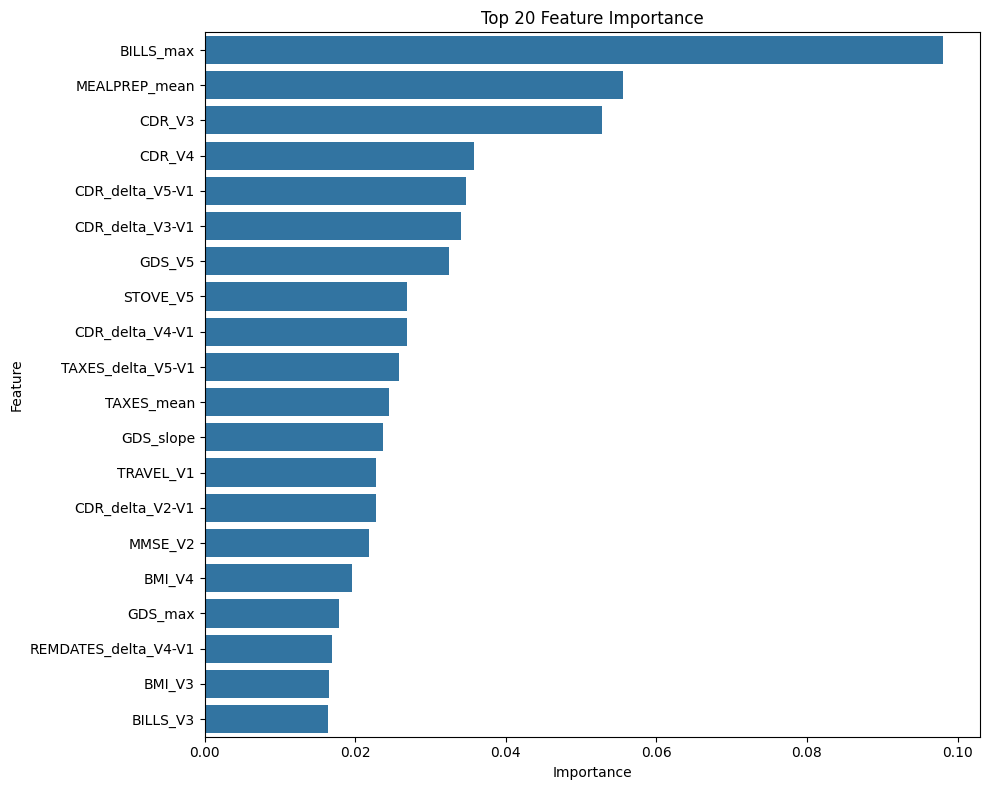

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('Dataset_1//5visit_CN_MCI.csv')

def create_target_variable(row):
    """Create binary target from Progression column (1=progressed, 0=stable)"""
    progression = eval(row['Progression'])  # Convert string tuple to actual tuple
    return 1 if 1 in progression else 0  # 1 if progressed to AD at any visit

def create_delta_features(df):
    """
    Enhanced version that:
    1. Safely parses array strings first
    2. Handles mixed numeric/non-numeric data
    3. Creates features for variable visit lengths
    """
    df = df.copy()
    
    # First pass: Convert all array-strings to lists of floats
    for col in df.columns:
        if df[col].dtype == object and df[col].str.startswith('[').any():
            df[col] = df[col].apply(
                lambda x: [float(v.strip()) if v.strip() != 'nan' else np.nan 
                         for v in x.replace('[','').replace(']','').split(',')] 
                if isinstance(x, str) and x.startswith('[') else np.nan
            )
    
    # Second pass: Create features only for numeric arrays
    for col in df.columns:
        if isinstance(df[col].iloc[0], list) and all(isinstance(v, (int, float)) for v in df[col].iloc[0] if not pd.isna(v)):
            max_visits = max(len(v) for v in df[col] if isinstance(v, list))
            
            # 1. Individual visit values
            for i in range(max_visits):
                df[f"{col}_V{i+1}"] = df[col].apply(
                    lambda x: x[i] if isinstance(x, list) and i < len(x) else np.nan
                )
            
            # 2. Deltas from baseline (V1)
            for i in range(1, max_visits):
                df[f"{col}_delta_V{i+1}-V1"] = df[col].apply(
                    lambda x: x[i]-x[0] if isinstance(x, list) and len(x) > i else np.nan
                )
            
            # 3. Slope of linear trend
            def calc_slope(x):
                if isinstance(x, list) and len(x) > 1:
                    x_vals = np.arange(len(x))
                    y_vals = np.array(x)
                    valid = ~np.isnan(y_vals)
                    if sum(valid) > 1:  # Need at least 2 points
                        return linregress(x_vals[valid], y_vals[valid]).slope
                return np.nan
                
            df[f"{col}_slope"] = df[col].apply(calc_slope)
            
            # 4. Aggregates
            df[f"{col}_mean"] = df[col].apply(
                lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
            )
            df[f"{col}_max"] = df[col].apply(
                lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
            )
    
    # Drop original array columns (keep only engineered features)
    array_cols = [col for col in df.columns if isinstance(df[col].iloc[0], list)] if len(df) > 0 else []
    df = df.drop(columns=array_cols)
    
    return df

# Preprocess the data
def preprocess_data(df):
    # Create target variable
    df['target'] = df.apply(create_target_variable, axis=1)
    
    # Get all available features (after create_delta_features transformation)
    all_features = [col for col in df.columns if col != 'target']
    
    # Select features we want to keep
    # Static features (non-time-series)
    static_features = [
        'SEX', 'EDUC', 'ALCOHOL', 'NACCFAM', 'CVHATT', 
        'CVAFIB', 'DIABETES', 'HYPERCHO', 'HYPERTEN', 'B12DEF', 'DEPD', 
        'ANX', 'NACCTBI', 'SMOKYRS', 'RACE', 'age'
    ]
    
    # Time-series features (we'll keep all of them)
    time_series_features = [col for col in all_features if '_V' in col or '_delta_' in col or '_slope' in col or '_mean' in col or '_max' in col]
    
    # Only keep features that actually exist in the dataframe
    static_features = [f for f in static_features if f in df.columns]
    
    # Combine all features
    features = static_features + time_series_features
    
    # Handle missing values
    df = df[features + ['target']].copy()
    df = df.dropna(subset=features, how='all')
    
    # Convert categorical variables
    categorical_cols = ['SEX', 'NACCFAM', 'CVHATT', 'CVAFIB', 'DIABETES', 
                       'HYPERCHO', 'HYPERTEN', 'B12DEF', 'DEPD', 'ANX', 'NACCTBI', 'RACE']
    categorical_cols = [col for col in categorical_cols if col in df.columns]  # Only keep existing cols
    for col in categorical_cols:
        df[col] = df[col].astype('category').cat.codes  # Convert to numeric codes
    
    return df

# Process the data
df_processed = create_delta_features(df)
processed_df = preprocess_data(df_processed)

# Check class distribution
print("Class distribution:")
print(processed_df['target'].value_counts())

def build_model(data):
    # Separate features and target
    X = data.drop('target', axis=1)
    y = data['target']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Handle class imbalance
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train) if sum(y_train) > 0 else 1
    
    # Train XGBoost model
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    
    return model, X.columns

# Build and evaluate the model
model, feature_names = build_model(processed_df)

def plot_feature_importance(model, feature_names, top_n=20):
    # Get feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
    plt.title(f'Top {top_n} Feature Importance')
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(model, feature_names)

4-15-25 Gathering statistics on classifer performance for 2visit - 6visit, testing classifier on each group, CN MCI, MCI AD
Recording top 10 feature importance

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//6visit_MCI_AD.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.11      1.00      0.20         1
           1       1.00      0.58      0.73        19

    accuracy                           0.60        20
   macro avg       0.56      0.79      0.47        20
weighted avg       0.96      0.60      0.71        20


ROC AUC Score: 0.6316


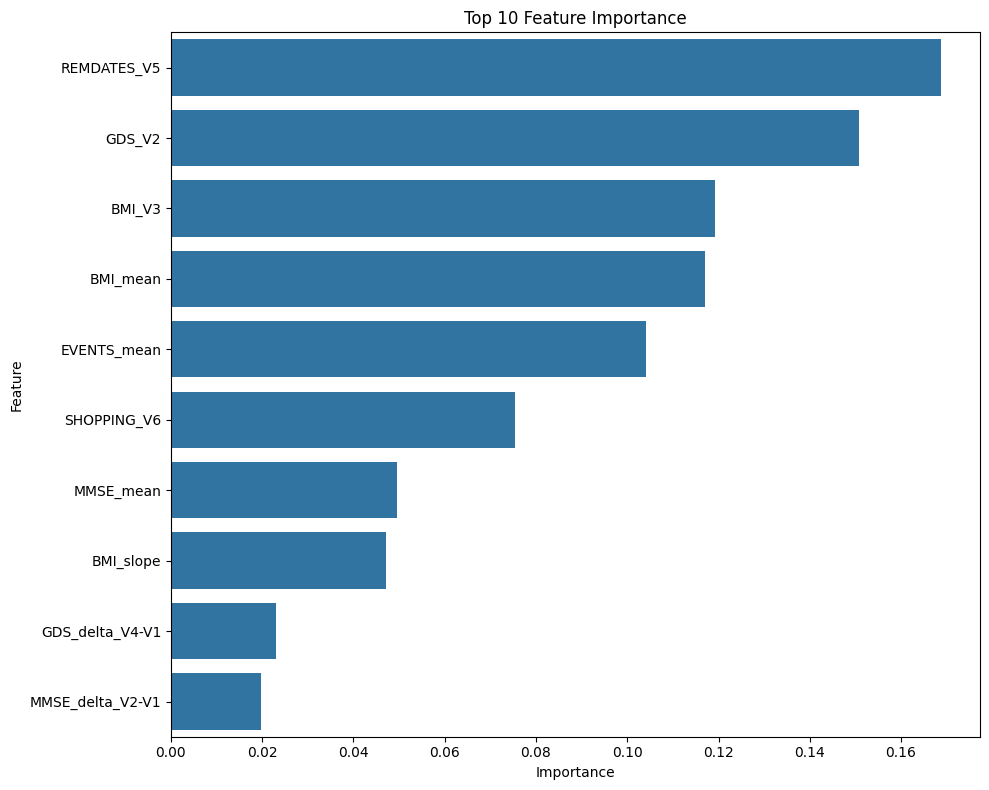

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//5visit_MCI_AD.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.96      0.92      0.94        26

    accuracy                           0.89        28
   macro avg       0.65      0.71      0.67        28
weighted avg       0.92      0.89      0.90        28


ROC AUC Score: 0.8654


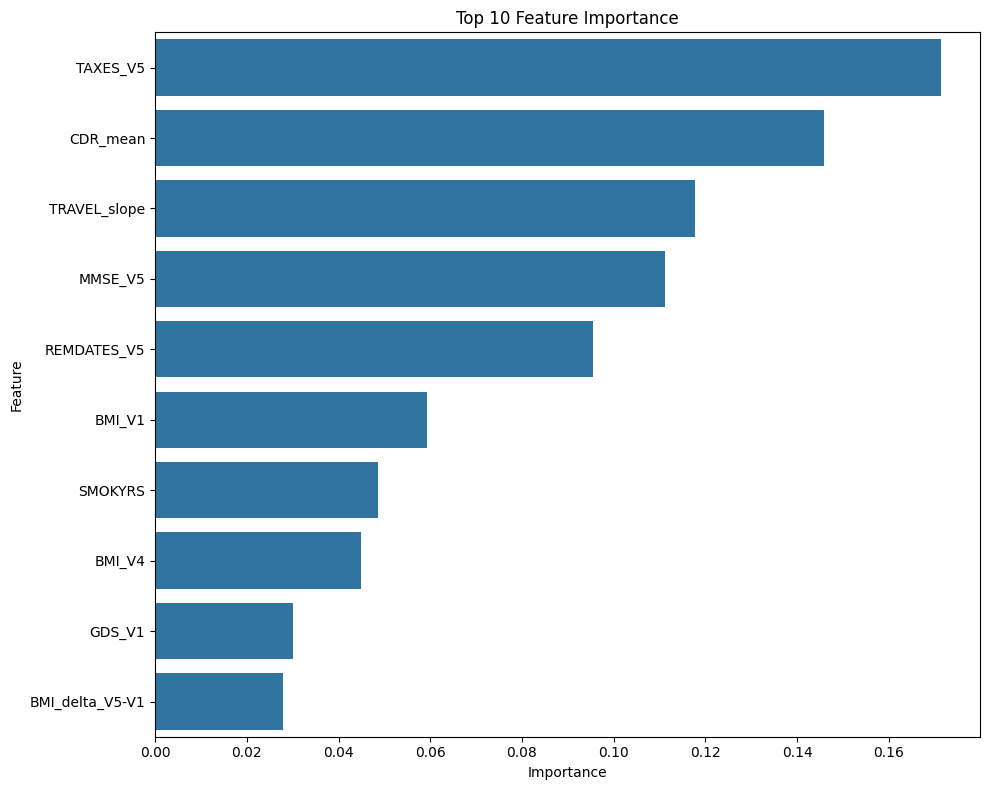

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//4visit_MCI_AD.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.91      0.95      0.93        42

    accuracy                           0.88        49
   macro avg       0.75      0.69      0.72        49
weighted avg       0.86      0.88      0.87        49


ROC AUC Score: 0.8299


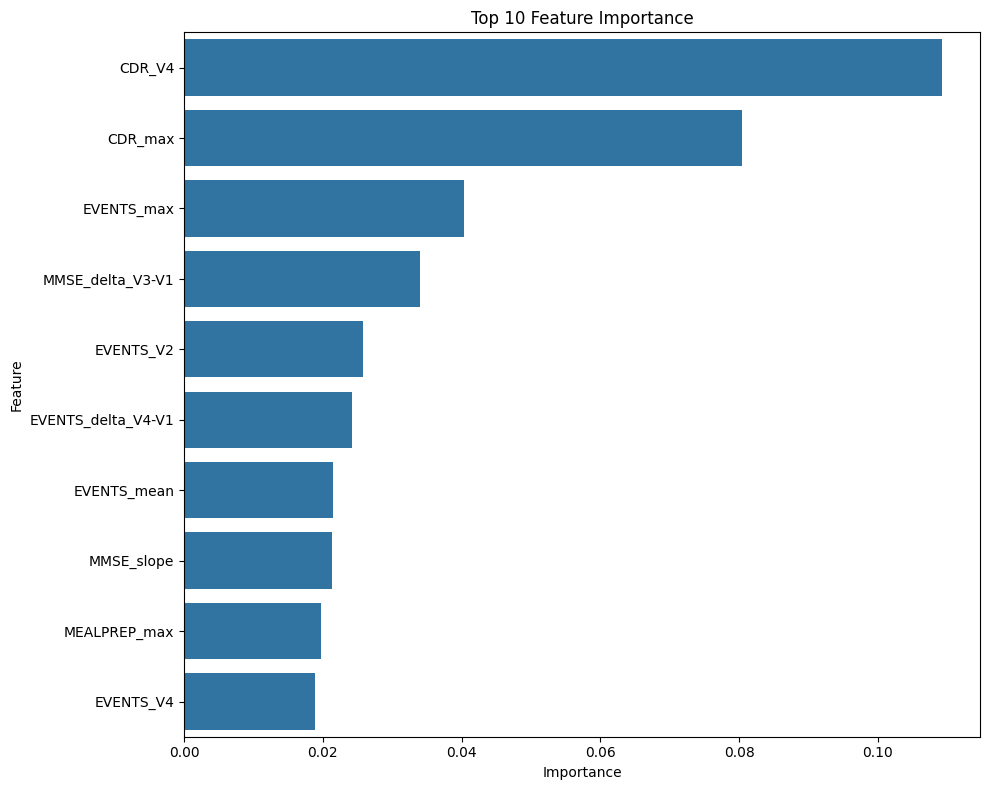

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//3visit_MCI_AD.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        17
           1       0.86      0.86      0.86        43

    accuracy                           0.80        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.80      0.80      0.80        60


ROC AUC Score: 0.7893


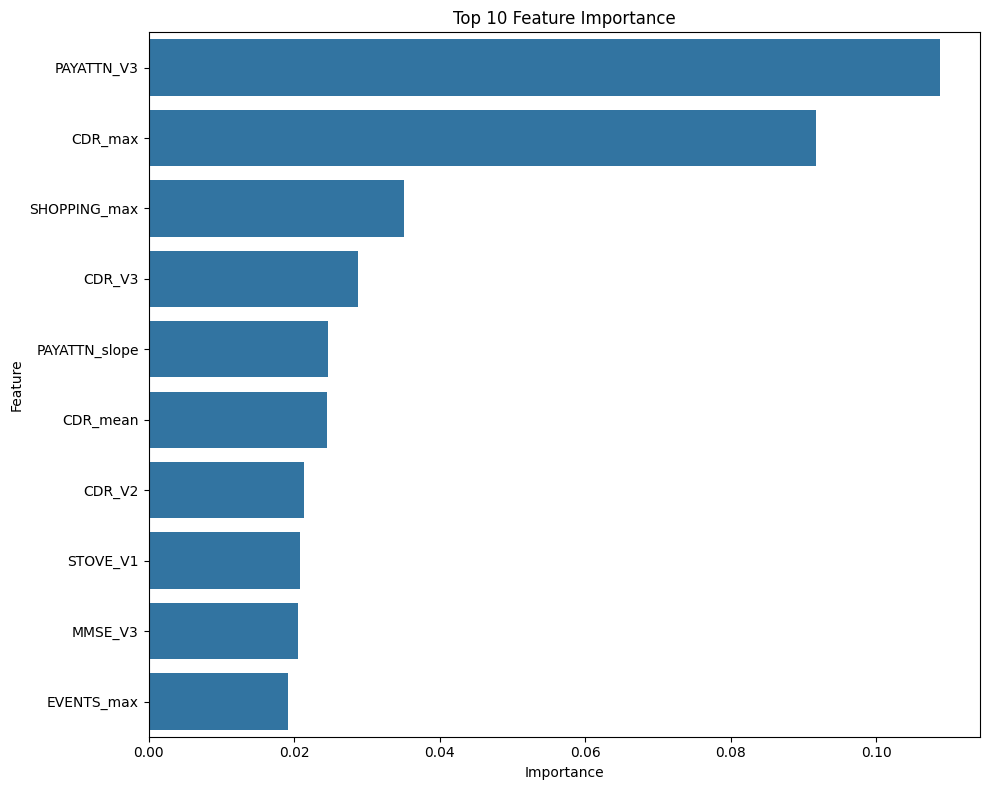

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//2visit_MCI_AD.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        45
           1       0.68      0.61      0.64        44

    accuracy                           0.66        89
   macro avg       0.66      0.66      0.66        89
weighted avg       0.66      0.66      0.66        89


ROC AUC Score: 0.7040


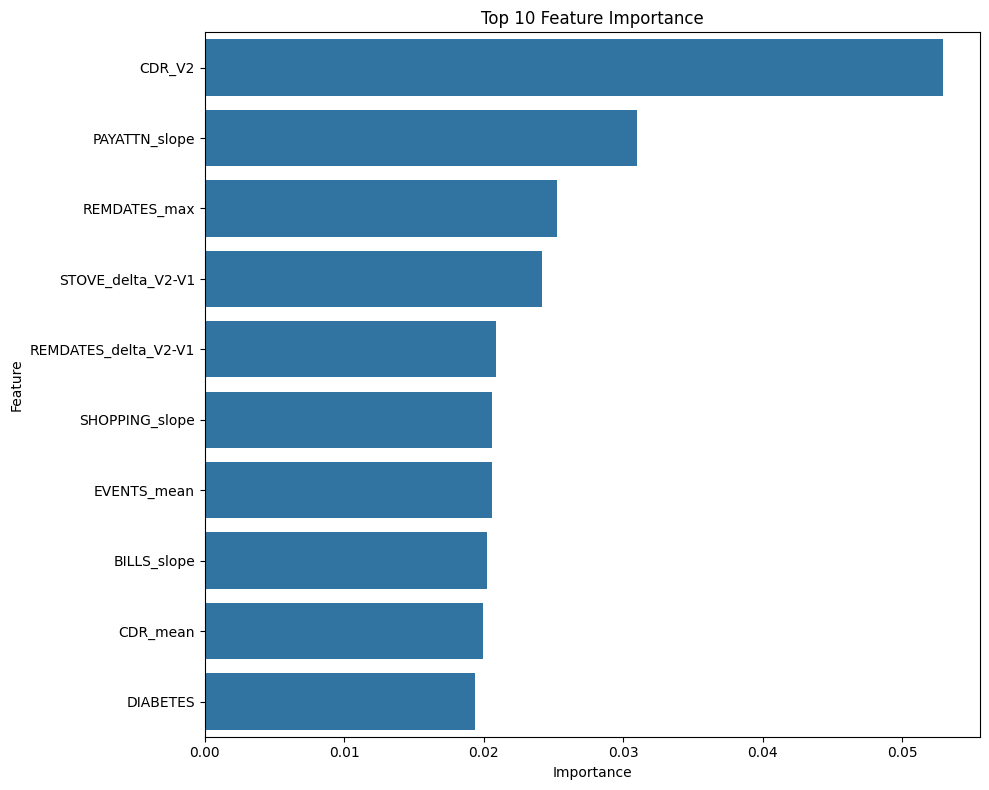

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//6visit_CN_MCI.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        78
           1       0.50      0.20      0.29         5

    accuracy                           0.94        83
   macro avg       0.73      0.59      0.63        83
weighted avg       0.92      0.94      0.93        83


ROC AUC Score: 0.7128


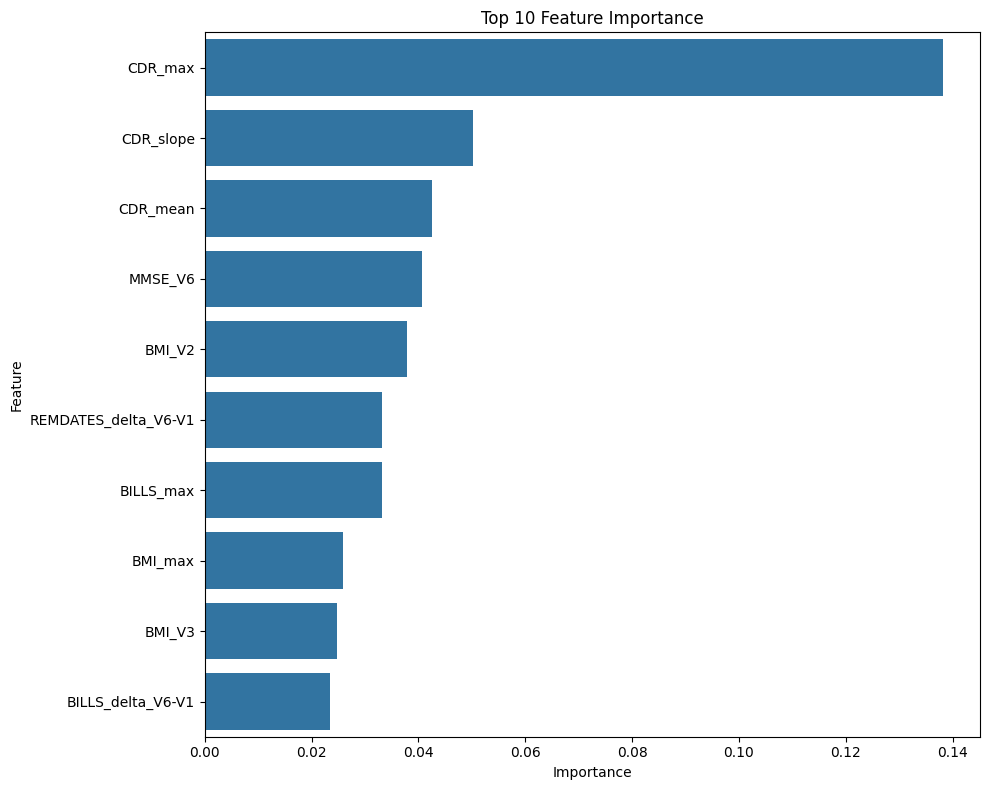

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//5visit_CN_MCI.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        86
           1       0.67      0.50      0.57         4

    accuracy                           0.97        90
   macro avg       0.82      0.74      0.78        90
weighted avg       0.96      0.97      0.96        90


ROC AUC Score: 0.9012


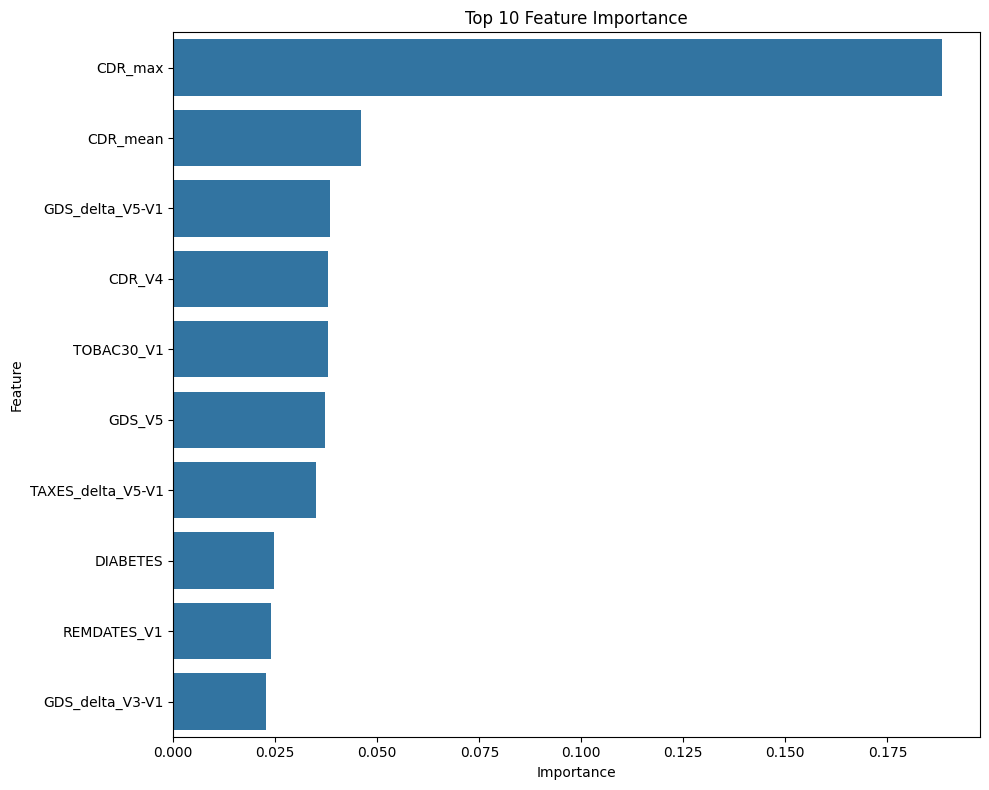

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//4visit_CN_MCI.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       111
           1       0.50      0.43      0.46         7

    accuracy                           0.94       118
   macro avg       0.73      0.70      0.72       118
weighted avg       0.94      0.94      0.94       118


ROC AUC Score: 0.9434


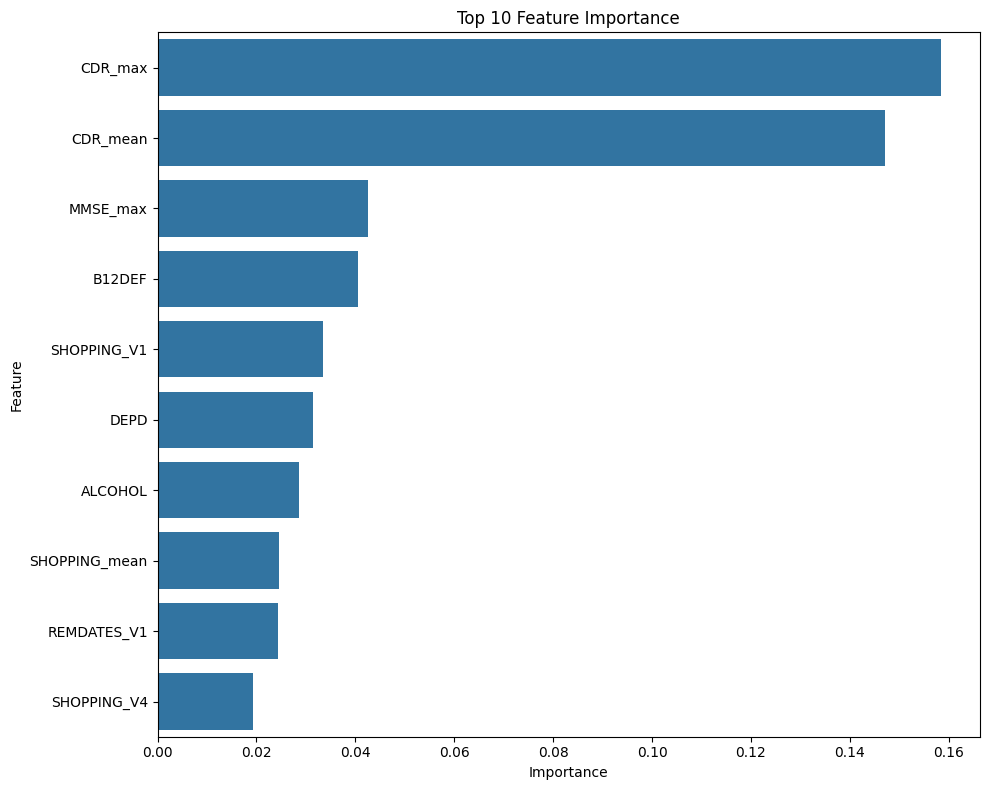

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//3visit_CN_MCI.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       115
           1       0.67      0.60      0.63        10

    accuracy                           0.94       125
   macro avg       0.82      0.79      0.80       125
weighted avg       0.94      0.94      0.94       125


ROC AUC Score: 0.9704


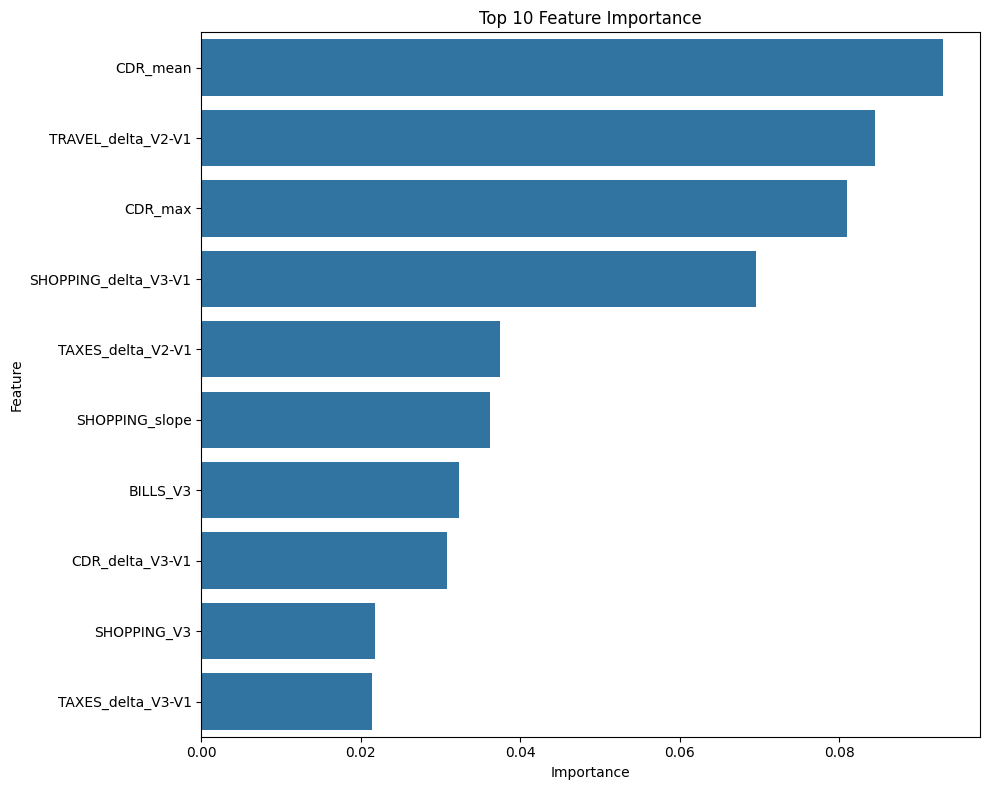

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:73: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:76: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan


Processed Dataset_1//2visit_CN_MCI.csv and plotted feature importance.
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       209
           1       0.33      0.31      0.32        16

    accuracy                           0.91       225
   macro avg       0.64      0.63      0.64       225
weighted avg       0.90      0.91      0.91       225


ROC AUC Score: 0.7279


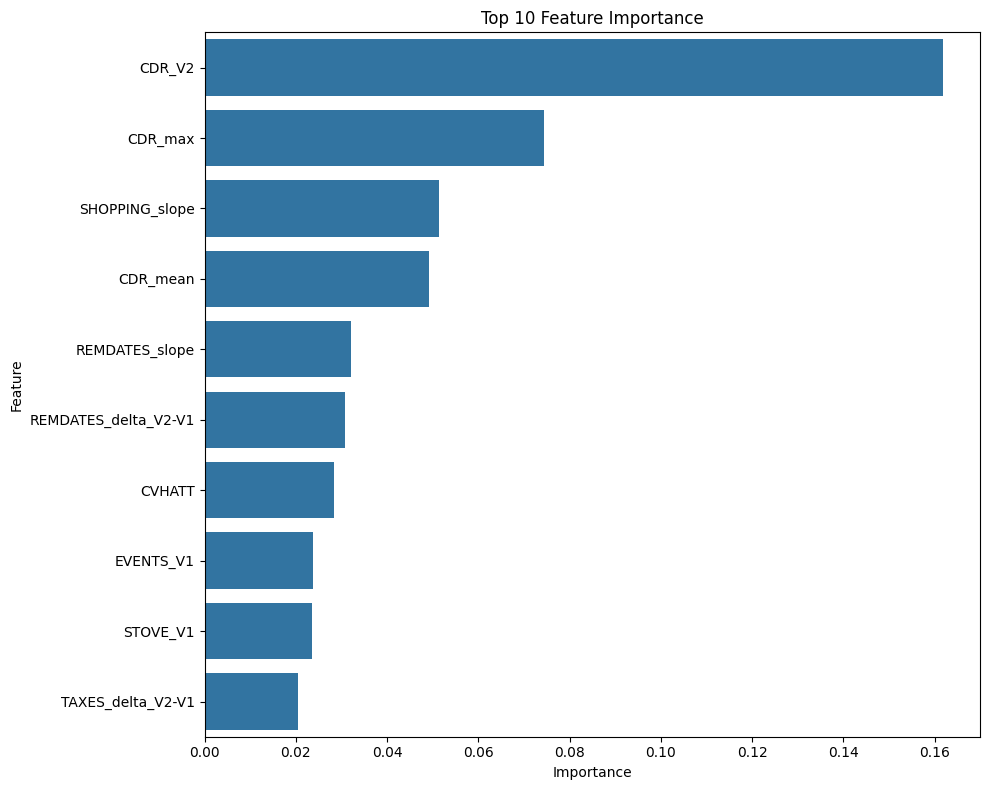

In [2]:
from xgboost_classifier import plot_feature_importance, build_model, create_delta_features, preprocess_data

ad_files = ['Dataset_1//6visit_MCI_AD.csv','Dataset_1//5visit_MCI_AD.csv', 'Dataset_1//4visit_MCI_AD.csv','Dataset_1//3visit_MCI_AD.csv', 'Dataset_1//2visit_MCI_AD.csv']
mci_files =['Dataset_1//6visit_CN_MCI.csv','Dataset_1//5visit_CN_MCI.csv', 'Dataset_1//4visit_CN_MCI.csv', 'Dataset_1//3visit_CN_MCI.csv', 'Dataset_1//2visit_CN_MCI.csv' ]
for file in ad_files:
    df = pd.read_csv(file)
    df = create_delta_features(df)
    processed_df = preprocess_data(df, 'AD')
    print(f"Processed {file} and plotted feature importance.")
    model, feature_names = build_model(processed_df)
    plot_feature_importance(model, feature_names, top_n=10)
for file in mci_files:
    df = pd.read_csv(file)
    df = create_delta_features(df)
    processed_df = preprocess_data(df, 'MCI')
    print(f"Processed {file} and plotted feature importance.")
    model, feature_names = build_model(processed_df)
    plot_feature_importance(model, feature_names, top_n=10)    
    
    

4-17-25

Testing out a new function in the classifier model to aggregate features and produce a heatmap for feature correlation. 

c:\Users\Andrew\Desktop\AGE\xgboost_classifier.py:147: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan


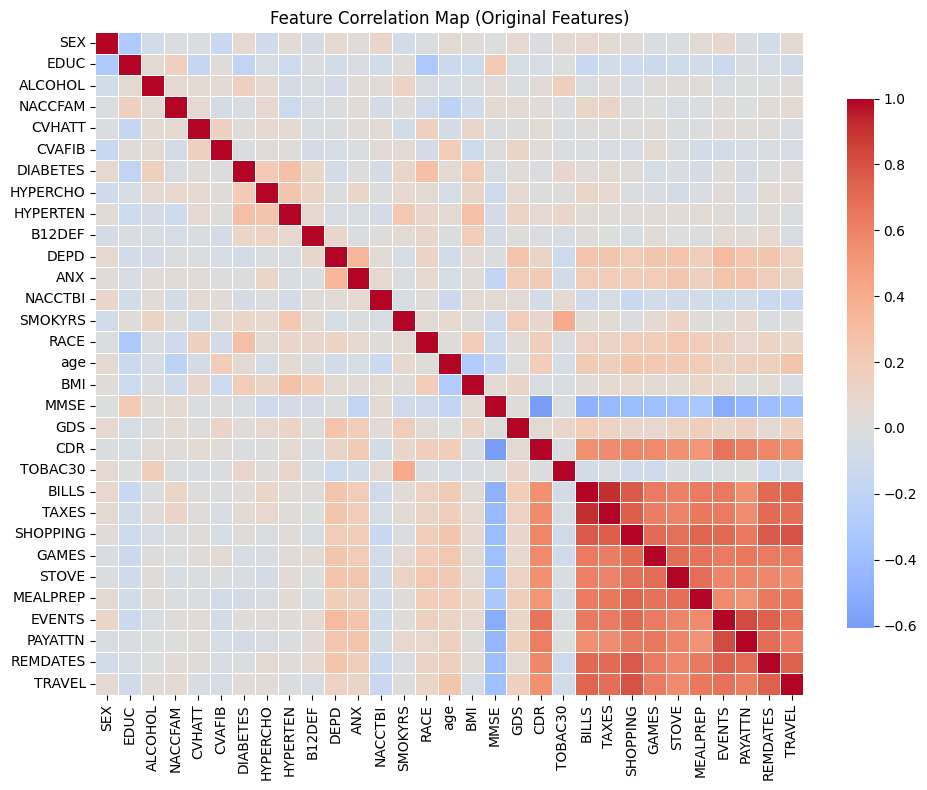

In [ ]:
from xgboost_classifier import  aggregate_original_features, plot_feature_correlation
df = pd.read_csv('Dataset_1//3visit_MCI_AD.csv')
aggregated_df = aggregate_original_features(df)
fig_size = (10, 8)
plot_feature_correlation(aggregated_df, fig_size)